In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

In [120]:
dogs_train = pd.read_csv('dogs_train.csv')
X_train = dogs_train.drop(['BreedGroupId', 'IsOldPet', 'Breed', 'Gender', 'Neutered', 'Age segment'], axis = 1)
y_train = dogs_train['BreedGroupId']
feats = X_train.columns

In [122]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
dog_df = pd.concat([y_train, pd.DataFrame(X_train, columns = feats)], axis = 1)

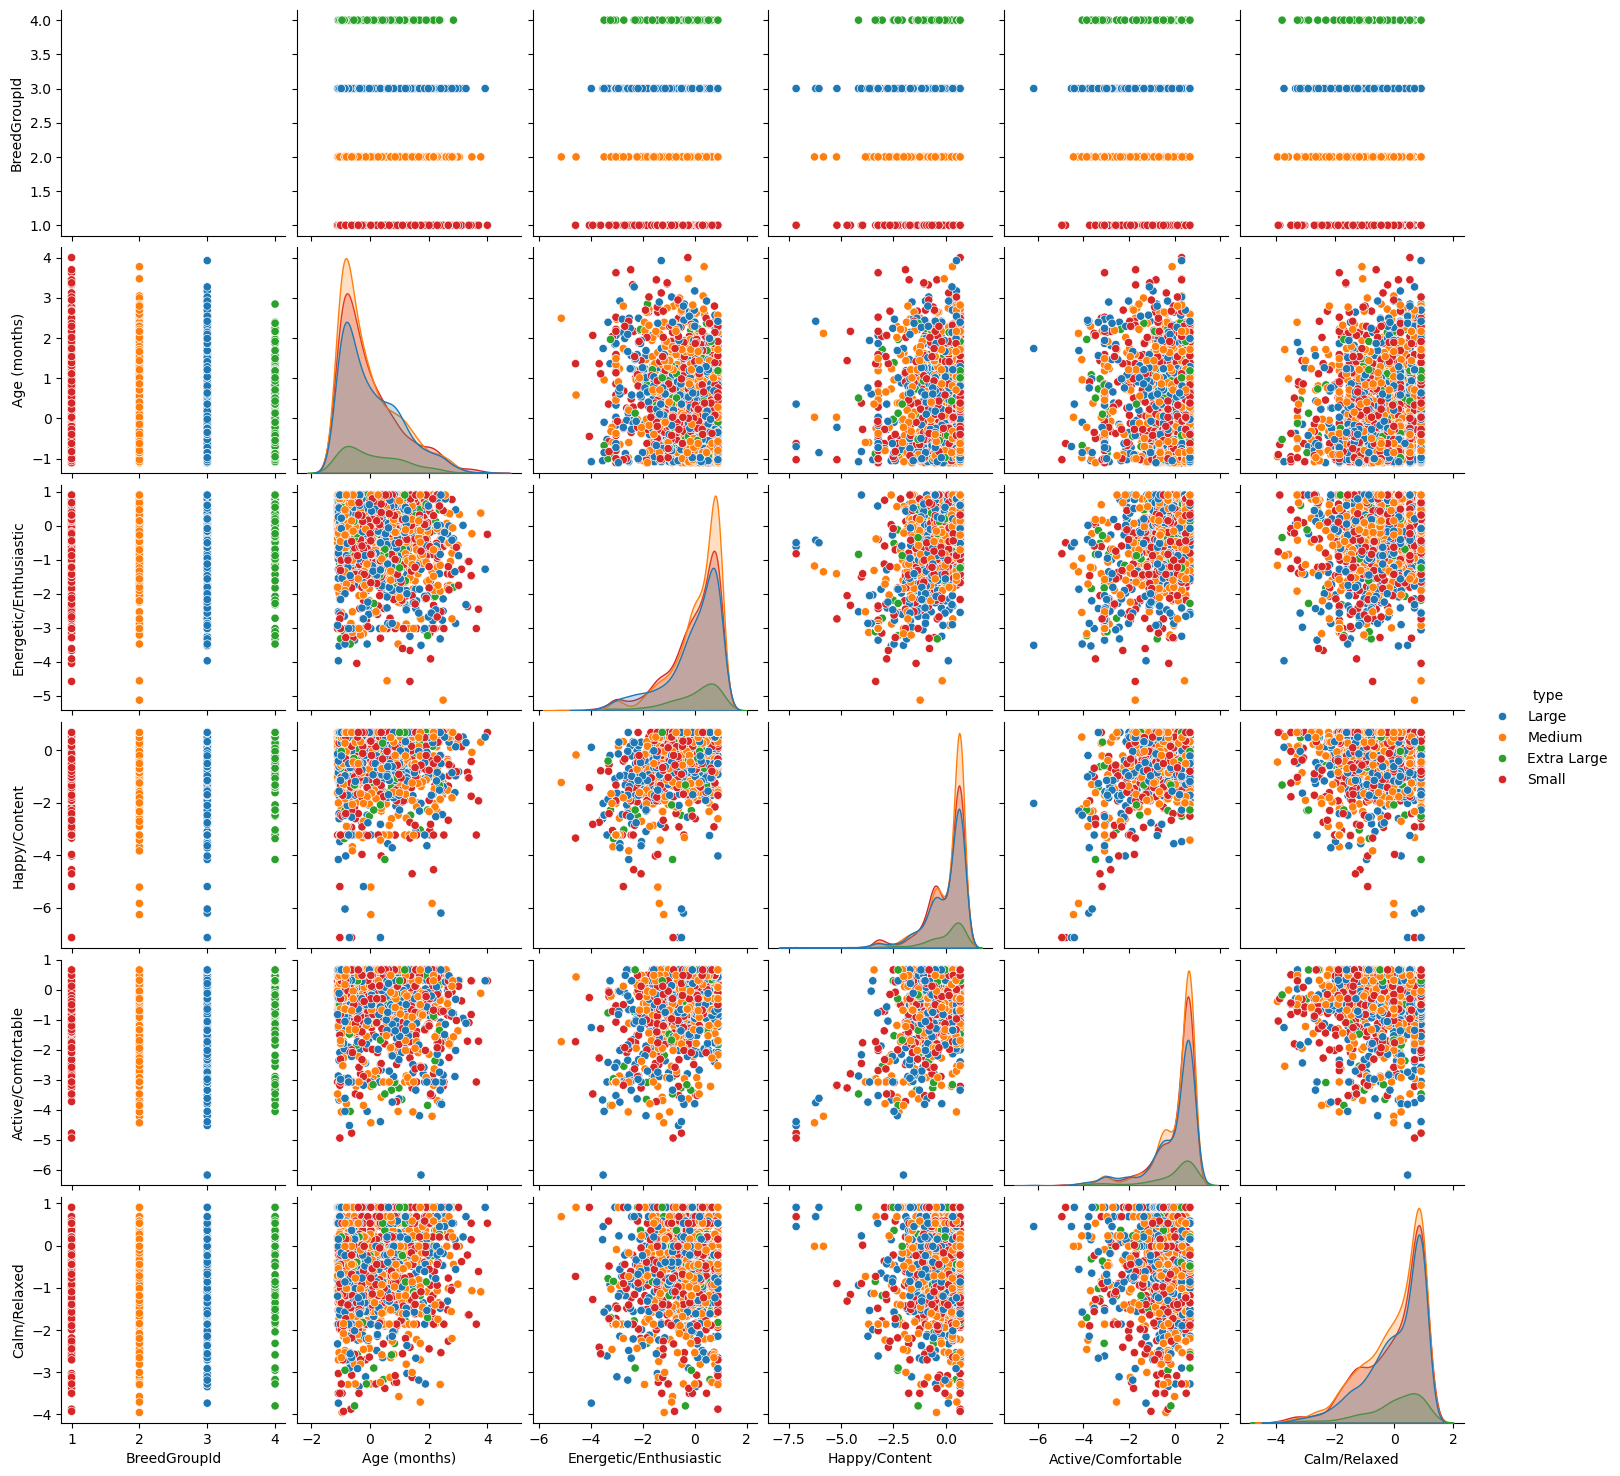

In [123]:
dog_df = pd.DataFrame(data = dog_df, columns = dog_df.columns.tolist())
dog_df['type'] = pd.DataFrame(data = y_train)
label_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'}
dog_df['type'] = dog_df.type.map(label_dict)
sns.pairplot(dog_df, hue = "type")
plt.show()

In [124]:
X2_train = X_train[:, [3, 4]] # Variables: Active vs Content
y2_train = y_train - 1

In [161]:
X3_train = torch.tensor(X2_train, dtype = torch.float)
y3_train = torch.tensor(y2_train, dtype = torch.int)

n_samples, n_features = X2_train.shape


lr = 0.001
n_epoch = 5000
thres = 0.001

In [162]:
class MultiClassLogisticRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = nn.Softmax()(logits)
        return logits, probas

model2 = MultiClassLogisticRegression(num_features = n_features, num_classes = 4)
optimizer = torch.optim.SGD(model2.parameters(), lr = lr)
lossfunc = nn.CrossEntropyLoss()

In [163]:
def comp_accuracy(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() == 
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy

train_loss = []
Time = n_epoch

for epoch in range(n_epoch):
    
    logits, probas = model2(X3_train)
    loss = lossfunc(logits, y3_train.long())    #nn.CrossEntropyLoss applies softmax already
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()
    

    model2.eval()    
    with torch.inference_mode(): 
    
        logits, probas = model2(X3_train)
        acc = comp_accuracy(y3_train, torch.argmax(probas, dim = 1))

        if (epoch + 1) % 500 == 0:
            print('Epoch: %03d' % (epoch + 1), end = "")
            print(' | Train ACC: %.3f' % acc, end = "")
            print(' | Cost: %.3f' % lossfunc(logits, y3_train.long()))
        
        if np.abs(model2.linear.weight.grad.max()) < thres: 
            Time = epoch + 1
            break
        
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 500 | Train ACC: 0.346 | Cost: 1.364
Epoch: 1000 | Train ACC: 0.347 | Cost: 1.346
Epoch: 1500 | Train ACC: 0.346 | Cost: 1.331
Epoch: 2000 | Train ACC: 0.346 | Cost: 1.320
Epoch: 2500 | Train ACC: 0.348 | Cost: 1.310
Epoch: 3000 | Train ACC: 0.348 | Cost: 1.303
Epoch: 3500 | Train ACC: 0.348 | Cost: 1.296
Epoch: 4000 | Train ACC: 0.349 | Cost: 1.291
Epoch: 4500 | Train ACC: 0.349 | Cost: 1.286
Epoch: 5000 | Train ACC: 0.349 | Cost: 1.282

Model parameters:
  Weights: Parameter containing:
tensor([[ 0.0256, -0.0219],
        [ 0.0554, -0.0257],
        [-0.0671,  0.0525],
        [-0.0139, -0.0048]], requires_grad=True)
  Bias: Parameter containing:
tensor([ 0.1967,  0.2755,  0.1126, -0.5848], requires_grad=True)


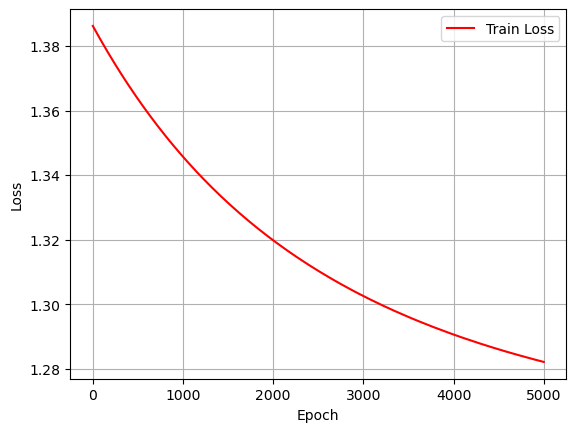

In [164]:
fig=plt.figure()
xv=np.arange(1,Time,1)
plt.plot(xv,train_loss[1:], 'r', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [165]:
def plot_decision_boundary_torch(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    _, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

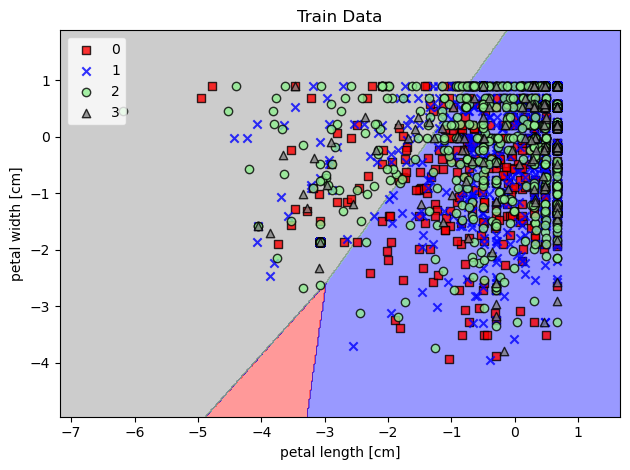

In [166]:
plot_decision_boundary_torch(X3_train, y3_train, classifier=model2)
plt.title("Train Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()